In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers 
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from tensorflow.keras.applications import MobileNetV2

In [3]:
BATCH_SIZE = 16
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=10

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage2",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [7]:
class_names = dataset.class_names

In [10]:
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

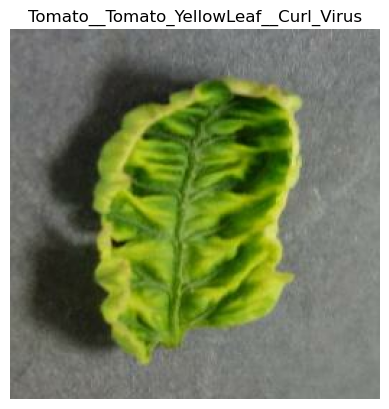

In [12]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

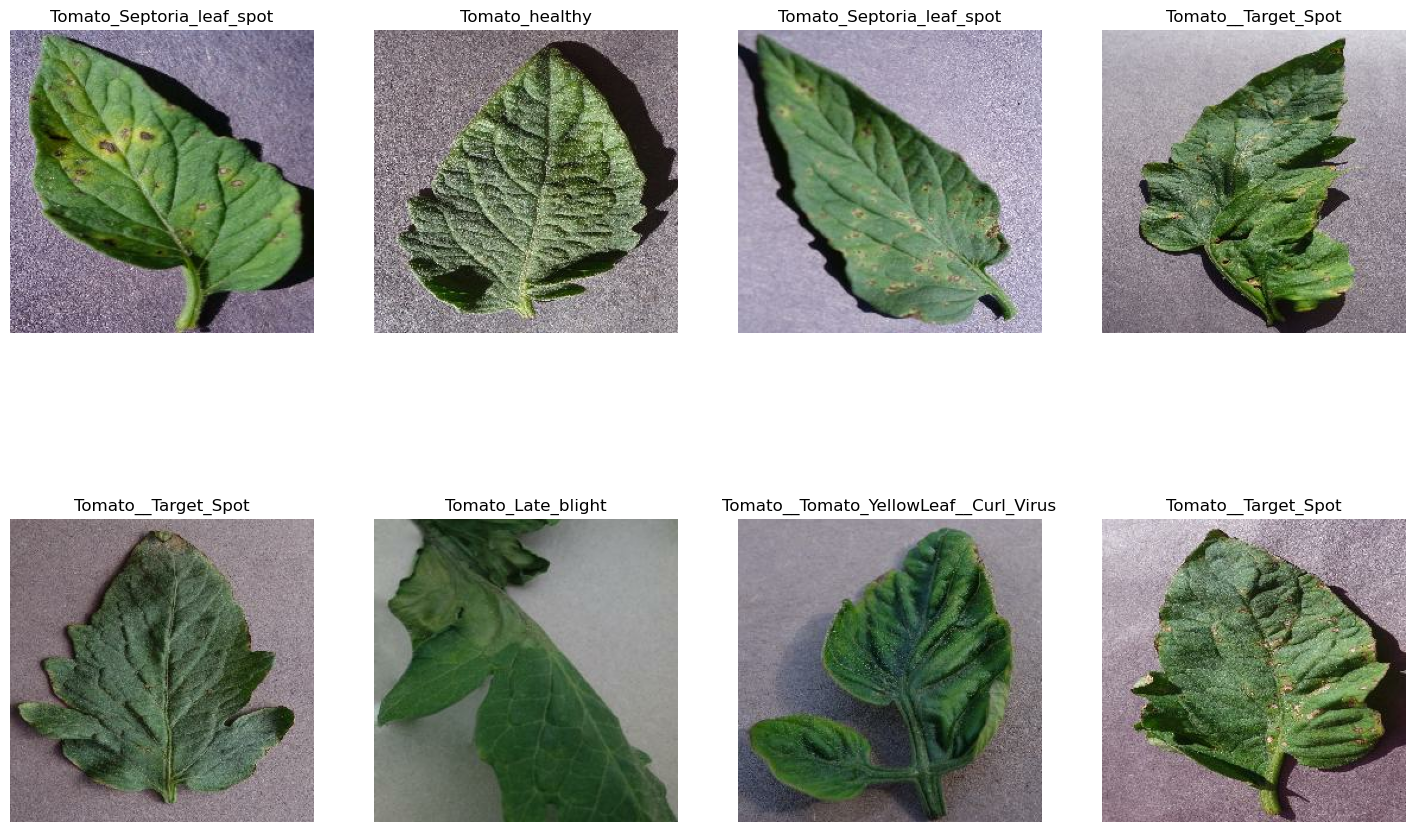

In [14]:

plt.figure(figsize=(18, 18))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [16]:
len(dataset)

1001

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [22]:
len(train_ds)

800

In [24]:
len(val_ds)

100

In [26]:
len(test_ds)

101

In [28]:
len(dataset)*0.8

800.8000000000001

In [30]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [32]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, 
                  IMAGE_SIZE),
  layers.Rescaling(scale=1./255),
])

In [34]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip(mode="horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [36]:
image_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
image_shape

(16, 256, 256, 3)

In [45]:
numClasses = 10
baseModel = tf.keras.applications.MobileNetV3Large(input_shape=(256, 256,3), weights='imagenet', include_top=False, classes=numClasses)
baseModel.trainable = False

last_output = baseModel.layers[-1].output
x = tf.keras.layers.GlobalAveragePooling2D()(last_output)
x = tf.keras.layers.Dropout(0.45) (x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.45) (x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input,outputs=x)




In [46]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 256, 256,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 128, 128,  │        432 │ rescaling_3[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 128, 128,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_40       │ (None, 128, 128,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        144 │ activation_40[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_38 (ReLU)     │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        256 │ re_lu_38[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 128, 128,  │          0 │ activation_40[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 128, 128,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 128, 128,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_39 (ReLU)     │ (None, 128, 128,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 129, 129,  │          0 │ re_lu_39[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 64, 64,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 64, 64,    │        256 │ expanded_conv_1_

 Total params: 3,248,778 (12.39 MB)

 Trainable params: 250,506 (978.54 KB)

 Non-trainable params: 2,998,272 (11.44 MB)

In [49]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [51]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,

    validation_data=val_ds,
  
    verbose=1,
    epochs=10,
)

Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 375s 388ms/step - accuracy: 0.6462 - loss: 1.1039 - val_accuracy: 0.9388 - val_loss: 0.2180
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 227s 284ms/step - accuracy: 0.8428 - loss: 0.4668 - val_accuracy: 0.9494 - val_loss: 0.1851
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 218s 273ms/step - accuracy: 0.8585 - loss: 0.4183 - val_accuracy: 0.9625 - val_loss: 0.1535
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 219s 273ms/step - accuracy: 0.8673 - loss: 0.3847 - val_accuracy: 0.9694 - val_loss: 0.1267
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 226s 283ms/step - accuracy: 0.8835 - loss: 0.3303 - val_accuracy: 0.9762 - val_loss: 0.1137
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 220s 274ms/step - accuracy: 0.8927 - loss: 0.3150 - val_accuracy: 0.9725 - val_loss: 0.1255
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 215s 269ms/step - accuracy: 0.8931 - loss: 0.3049 - val_accuracy: 0.9787 - val_loss: 0.0982
Epoch 8/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 227s 284ms/step - accuracy: 0.8931 -

In [53]:
scores = model.evaluate(test_ds)
scores


101/101 ━━━━━━━━━━━━━━━━━━━━ 113s 271ms/step - accuracy: 0.9785 - loss: 0.0769


[0.07870122045278549, 0.9783415794372559]

In [55]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

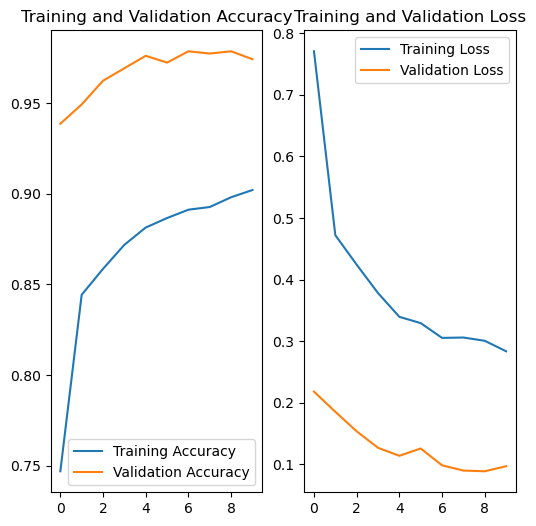

In [60]:
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato_Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
predicted label: Tomato_Late_blight


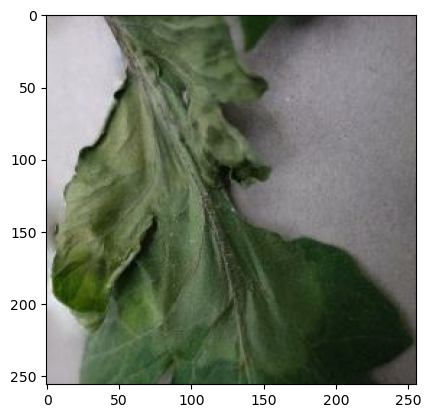

In [62]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [64]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


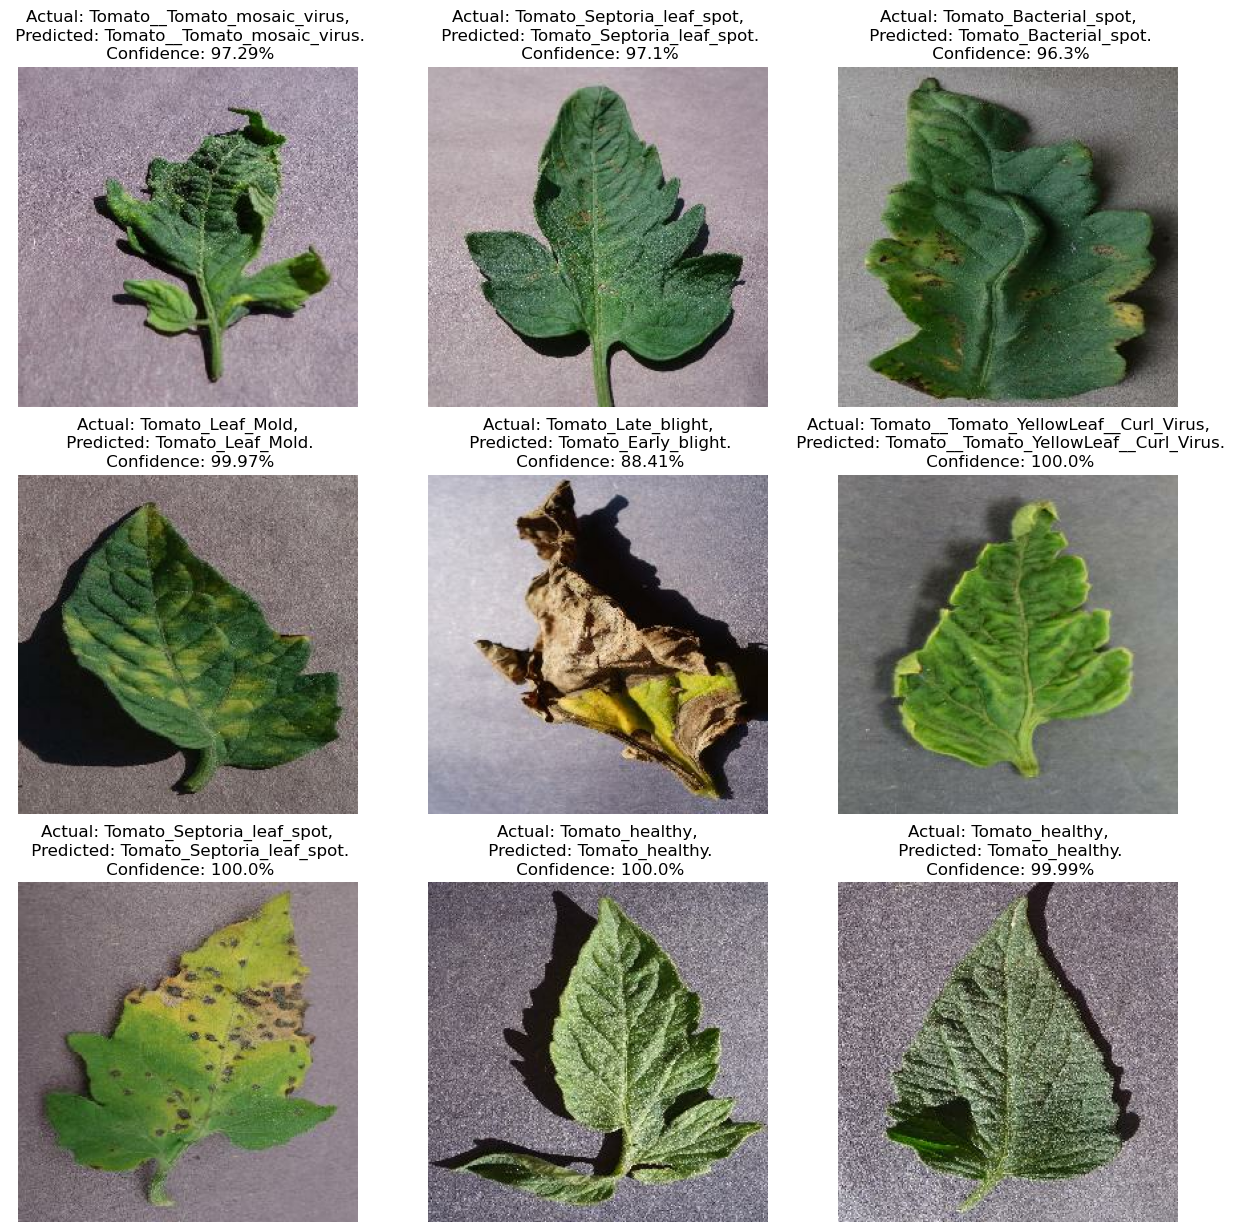

In [66]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [68]:
model.save("../models/2.keras")

In [72]:
model.save("../tomato.keras")